<a href="https://colab.research.google.com/github/FranciscoGlez25/CNN-TC/blob/main/InceptionV3_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configuración del Entorno y Dispositivo de GPU**

En este bloque de código, se importan las bibliotecas esenciales para la implementación y entrenamiento de modelos de aprendizaje profundo utilizando la biblioteca PyTorch. Se incluyen módulos clave como torch, torchvision, y otras utilidades para la manipulación de datos, optimización, y evaluación de modelos. Además, se verifica la disponibilidad de GPU para aprovechar el rendimiento de cómputo acelerado si está disponible.

In [ ]:
import torch
import torchvision
from torchvision.transforms import v2
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as img
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.nn import Linear, CrossEntropyLoss, Sequential

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

# **Realizar transformaciones adecuadas para el modelo**

En este fragmento de código, se importan y configuran las bibliotecas y transformaciones necesarias para el preprocesamiento de imágenes en el contexto de entrenamiento y evaluación de modelos de visión por computadora. La biblioteca torchvision se utiliza para acceder a conjuntos de datos, transformaciones y modelos preentrenados.

Se definen dos conjuntos de transformaciones: transform_train y transform_test. Estas transformaciones se aplican a las imágenes durante el entrenamiento y la evaluación, respectivamente. Las operaciones incluyen la conversión de imágenes a tensores, recorte y redimensionamiento, así como aumentación de datos como la inversión horizontal aleatoria durante el entrenamiento para mejorar la generalización del modelo. Además, se realiza la normalización de las imágenes de acuerdo con los valores de media y desviación estándar especificados.

Estas transformaciones son esenciales para garantizar que las imágenes de entrada estén en el formato adecuado y que el modelo pueda aprender de manera efectiva durante el entrenamiento, manteniendo un rendimiento consistente durante la evaluación.

In [ ]:
from torchvision import datasets, transforms, models

# Definir transformaciones para el preprocesamiento de las imágenes
transform_train = v2.Compose([v2.ToTensor(),
                    v2.CenterCrop(size = (850,850)),
                    v2.Resize(size = (299, 299)),
                    v2.RandomHorizontalFlip(p=0.5),
                    #v2.RandomEqualize(p = 1),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

transform_test = v2.Compose([v2.ToTensor(),
                    v2.CenterCrop(size = (850,850)),
                    v2.Resize(size = (299, 299)),
                    #v2.RandomEqualize(p = 1),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


# **Definir la clase CustomDataset para obtener las etiquetas del archivo .csv y las imágenes**

En este bloque de código, se define una clase llamada `CustomDataset` que hereda de la clase `Dataset` de PyTorch. Esta clase personalizada se utiliza para cargar imágenes y etiquetas desde un archivo CSV, permitiendo la creación de conjuntos de datos personalizados para entrenamiento y evaluación de modelos.

- **Constructor (`__init__`):** En el constructor, se inicializan las variables esenciales, como el archivo CSV, el directorio raíz de las imágenes y las transformaciones opcionales. Además, se calcula el número de clases únicas presentes en el conjunto de datos.

- **Método `__len__`:** Este método devuelve la longitud del conjunto de datos, es decir, el número total de muestras.

- **Método `__getitem__`:** Este método se utiliza para obtener una muestra específica del conjunto de datos en función de un índice dado. Se carga la imagen desde la ruta especificada en el archivo CSV, se convierte a formato RGB (si no lo está), y se obtiene la etiqueta correspondiente. Si se proporcionan transformaciones, se aplican a la imagen.

La utilización de esta clase personalizada facilita la gestión de conjuntos de datos estructurados en archivos CSV, permitiendo una integración sencilla con las herramientas de manipulación de datos y entrenamiento de PyTorch.

In [ ]:
# Definir dataset personalizado para cargar imágenes y clases desde archivos CSV
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Obtener el número de clases desde el conjunto de datos
        self.num_classes = len(self.annotations['Egreso'].unique())  # Suponiendo que la columna de etiquetas se llama 'label'

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.annotations.iloc[index, 3]

        if self.transform:
            image = self.transform(image)

        return image, label

# **Montaje de Google Drive en Colab**


En este bloque de código, se utiliza la biblioteca `google.colab` para montar Google Drive en el entorno de ejecución de Google Colab. Google Drive es una plataforma de almacenamiento en la nube, y montarlo en Colab permite acceder y manipular archivos almacenados en Google Drive directamente desde el entorno de ejecución.

1. **Importación de la Biblioteca:**
   Se importa la biblioteca `drive` desde `google.colab`.

2. **Montaje de Google Drive:**
   La función `drive.mount('/content/drive')` se utiliza para montar Google Drive en el directorio `/content/drive` de Colab. Al ejecutar esta celda, aparecerá un enlace para autorizar el acceso a Google Drive. Después de la autorización, se generará un código de autenticación que debe ser copiado y pegado en un campo de entrada en la celda para completar el proceso de montaje.

Este bloque es esencial cuando se trabaja con archivos almacenados en Google Drive desde un entorno de ejecución en Google Colab. Una vez montado, se pueden acceder a los archivos de Google Drive como si fueran archivos locales en la ruta `/content/drive`.

In [ ]:
from google.colab import drive

# Monta Google Drive en el entorno de ejecución
drive.mount('/content/drive')

# **Creación del Conjunto de Datos y DataLoader**

En este fragmento de código, se utilizan las clases `DataLoader` y `random_split` de PyTorch para gestionar el conjunto de datos de entrenamiento. Además, se crea una instancia de la clase `CustomDataset` para cargar imágenes y etiquetas desde un archivo CSV.

- **`DataLoader`:** Esta clase facilita la creación de un iterador sobre el conjunto de datos, permitiendo el acceso a las muestras en lotes durante el entrenamiento del modelo.

- **`random_split`:** Este método se utiliza para dividir el conjunto de datos en subconjuntos de entrenamiento y validación de manera aleatoria. La longitud de cada subconjunto se especifica proporcionalmente.

- **Creación del Conjunto de Datos:** Se crea un conjunto de datos de entrenamiento (`train_dataset`) utilizando la clase `CustomDataset`. Se especifica el archivo CSV, el directorio raíz de las imágenes y las transformaciones definidas anteriormente.

- **Longitud del Conjunto de Datos:** Se imprime la cantidad total de imágenes en el conjunto de datos de entrenamiento.

Este bloque de código establece las bases para la gestión eficiente de datos durante el entrenamiento del modelo, asegurando la aleatoriedad en la división del conjunto de datos y proporcionando una interfaz fácil de usar para cargar y procesar lotes de datos.

In [ ]:
from torch.utils.data import DataLoader, random_split

# Define el conjunto de datos completo
# La primer ruta corresponde al archivo .csv que contiene las etiquetas de las imágenes.
# La segunda ruta corresponde a la carpeta que contiene las imágenes a utilizar.
train_dataset = CustomDataset('ruta_archivo_csv', 'ruta_carpeta_imagenes', transform=transform_train)

total_train = len(train_dataset)
print(f'Cantidad total de imágenes en Train Dataset: {total_train}')

Cantidad total de imágenes en Train Dataset: 963


En este bloque de código, se realiza la división del conjunto de datos de entrenamiento en subconjuntos de entrenamiento y validación. También se calcula el número de muestras para cada conjunto y se definen los `DataLoaders` correspondientes.

- **Número Total de Muestras:** Se calcula el número total de muestras en el conjunto de entrenamiento.

- **Tamaño del Conjunto de Validación:** Se especifica el porcentaje de muestras que se destinará al conjunto de validación (en este caso, el 20%). Se calcula el tamaño correspondiente para el conjunto de validación.

- **Tamaño del Conjunto de Entrenamiento:** Se calcula el tamaño del conjunto de entrenamiento restando el tamaño del conjunto de validación al número total de muestras.

- **División del Conjunto de Datos:** Se utiliza la función `random_split` para dividir el conjunto de entrenamiento en conjuntos de entrenamiento y validación según los tamaños calculados.

- **Definición de DataLoaders:** Se crean instancias de `DataLoader` para el conjunto de entrenamiento (`train_loader`) y el conjunto de validación (`val_loader`). Se especifica el tamaño del lote y se activa la opción de mezcla (`shuffle`) para garantizar la aleatoriedad durante el entrenamiento.

Este bloque de código establece la estructura necesaria para iterar sobre lotes de datos durante el entrenamiento y la validación del modelo, lo que facilita el proceso de aprendizaje y evaluación. La aleatoriedad en la división y la mezcla de lotes contribuyen a mejorar la generalización del modelo.

In [ ]:
# Obtén el número total de muestras en el conjunto de entrenamiento
total_samples = len(train_dataset)

# Calcula el número de muestras para el conjunto de validación (por ejemplo, el 20%)
validation_split = 0.2
validation_size = int(validation_split * total_samples)

# Calcula el tamaño del conjunto de entrenamiento
train_size = total_samples - validation_size

# Divide el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Define los DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

En este fragmento de código, se obtiene la cantidad total de imágenes en los conjuntos de entrenamiento y validación a través de los `DataLoaders` previamente definidos. Luego, se imprime esta información para tener una visión general de la distribución de datos.

- **Número Total de Imágenes en `train_loader` y `val_loader`:** Se utiliza la propiedad `dataset` de los `DataLoaders` para acceder al conjunto de datos subyacente y obtener la cantidad total de imágenes tanto para el conjunto de entrenamiento como para el de validación.

- **Impresión de la Cantidad Total de Imágenes:** Se imprime la cantidad total de imágenes en el conjunto de entrenamiento después de realizar la división, así como la cantidad total de imágenes en el conjunto de validación.

Este bloque de código proporciona información útil sobre la distribución de datos en los conjuntos de entrenamiento y validación después de la división, lo que es crucial para comprender la cantidad de datos disponible para el entrenamiento y la evaluación del modelo.

In [ ]:
# Obtén la cantidad total de imágenes en train_loader y validation_loader
total_images_train = len(train_loader.dataset)
total_images_validation = len(val_loader.dataset)

# Imprime la cantidad total de imágenes
print(f'Cantidad total de imágenes en Train Dataset despues de realizar split: {total_images_train}')
print(f'Cantidad total de imágenes en Validation Dataset: {total_images_validation}')

Cantidad total de imágenes en Train Dataset despues de realizar split: 771
Cantidad total de imágenes en Validation Dataset: 192


# **Definición del Dataset de Prueba y DataLoader**

En este bloque de código, se define un conjunto de datos de prueba (`test_dataset`) utilizando la misma clase personalizada `CustomDataset` que se utilizó previamente para el conjunto de entrenamiento y validación. También se crea un `DataLoader` correspondiente (`test_loader`) para cargar lotes de datos durante la evaluación del modelo.

- **Creación del Conjunto de Datos de Prueba:** Se instancia un nuevo conjunto de datos de prueba (`test_dataset`) utilizando la clase `CustomDataset`. Se especifica el archivo CSV, el directorio raíz de las imágenes y las transformaciones de prueba (`transform_test`) definidas anteriormente.

- **Definición del DataLoader de Prueba:** Se crea un `DataLoader` (`test_loader`) para el conjunto de datos de prueba. Se especifica el tamaño del lote, y se activa la opción de mezcla (`shuffle`) para garantizar la aleatoriedad en la evaluación.

- **Número Total de Imágenes en `test_loader`:** Se utiliza la propiedad `dataset` del `test_loader` para acceder al conjunto de datos subyacente y se imprime la cantidad total de imágenes en el conjunto de prueba.

Este bloque de código establece las bases para la evaluación del modelo utilizando un conjunto de datos de prueba independiente. La aleatoriedad en la carga de lotes y la información sobre la cantidad total de imágenes son fundamentales para comprender la distribución de datos en el conjunto de prueba.

In [ ]:
# Definir dataset de validación y dataloader

test_dataset = CustomDataset('ruta_archivo_csv', 'ruta_carpeta_imagenes', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

total_images_test = len(test_loader.dataset)
print(f'Cantidad total de imágenes en Test Dataset: {total_images_test}')

Cantidad total de imágenes en Test Dataset: 241


En este fragmento de código, se accede al número de clases en el conjunto de datos de prueba (`test_dataset`) utilizando la propiedad `num_classes` que se define en la clase `CustomDataset`. Luego, se imprime esta información para conocer el número total de clases presentes en el conjunto de prueba.

- **Número de Clases en el Conjunto de Datos de Prueba:** Se accede al número de clases mediante la propiedad `num_classes` de la instancia del conjunto de datos de prueba (`test_dataset`).

- **Impresión del Número de Clases:** Se imprime el número total de clases presentes en el conjunto de prueba.

Este bloque de código proporciona información importante sobre la estructura del conjunto de datos de prueba y es esencial para configurar correctamente la capa de salida del modelo durante la evaluación y la inferencia.

In [ ]:
num_classes = test_dataset.num_classes
print("Clases obtenidas en el conjunto Test Dataset:", num_classes)

Clases obtenidas en el conjunto Test Dataset: 2


# **Carga del Modelo InceptionV3 y Modificación de la Capa de Clasificación**

En este bloque de código, se carga un modelo preentrenado InceptionV3 y se modifican las capas totalmente conectadas (FC) para adaptarse al problema específico. Luego, el modelo se mueve al dispositivo de entrenamiento (GPU si está disponible, de lo contrario, CPU). A continuación, se imprime el número de clases y se describen las modificaciones realizadas al modelo.

- **Carga del Modelo InceptionV3 Preentrenado:** Se utiliza la función `models.inception_v3` de PyTorch para cargar el modelo InceptionV3 preentrenado. Se establece la opción `pretrained=True` para cargar los pesos preentrenados en conjuntos de datos masivos.

- **Obtención del Número de Características de Entrada:** Se obtiene el número de características de entrada de la capa completamente conectada (`fc`) del modelo InceptionV3 preentrenado.

- **Definición de Nuevas Capas FC:** Se definen nuevas capas completamente conectadas (`fc0`, `fc1`, `fc2`, `fc3`) para adaptar la salida del modelo a las necesidades del problema específico. La última capa (`fc3`) tiene un número de neuronas igual al número de clases en el conjunto de datos de prueba.

- **Reemplazo de la Capa FC Existente:** Se reemplaza la capa FC existente en el modelo InceptionV3 preentrenado con las nuevas capas definidas.

- **Mover el Modelo al Dispositivo de Entrenamiento:** Se utiliza la función `to` para mover el modelo al dispositivo de entrenamiento (GPU si está disponible, de lo contrario, CPU).

- **Número de Clases en el Conjunto de Datos de Prueba:** Se imprime el número de clases obtenidas desde el conjunto de datos de prueba.

Este bloque de código configura el modelo InceptionV3 para el problema específico, reemplazando las capas FC y preparándolo para el entrenamiento en el dispositivo adecuado.

In [ ]:
# Cargar el modelo InceptionV3 pre-entrenado
model = models.inception_v3(pretrained=True, aux_logits=True)
num_features = model.fc.in_features  # Obtener el número de características de entrada
# Definir tus propias capas FC
fc0 = nn.Linear(num_features, 1024)
fc1 = nn.Linear(1024, 512)  # Agrega la primera capa FC con 512 neuronas
fc2 = nn.Linear(512, 256)  # Agrega la segunda capa FC con 256 neuronas
fc3 = nn.Linear(256, num_classes)  # Agrega la tercera capa FC con 2 neuronas (suponiendo 2 clases)

# Reemplazar la capa FC existente en InceptionV3 con tus nuevas capas FC
model.fc = nn.Sequential(
    fc0,
    nn.ReLU(),
    fc1,
    nn.ReLU(),  # Agrega una función de activación, por ejemplo, ReLU
    fc2,
    nn.ReLU(),  # Otra función de activación, por ejemplo, ReLU
    fc3
)

# Mover modelo a dispositivo de entrenamiento
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 84.6MB/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

# **Visualizamos la arquitectura del modelo**

In [ ]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

# **Resumen del Modelo con `torchsummary` (Opcional)**

In [ ]:
#Se utiliza el siguiente bloque para visualizar mejor la arquitectura que se utilizará:

from torchsummary import summary

# Mostrar un resumen del modelo con torchsummary
summary(model, input_size=(3, 299, 299))  # Ajustar las dimensiones de entrada según sea necesario


Para comprender mejor la arquitectura del modelo InceptionV3 personalizado, se utiliza la herramienta `torchsummary` para obtener un resumen conciso. Este resumen muestra las capas del modelo, el tamaño de salida de cada capa y la cantidad de parámetros entrenables.

```plaintext
=======================================================================
Layer (type:depth-idx)                        Output Shape              Param #
=======================================================================
├─Inception3: 1-1                             [-1, 2048, 8, 8]         --
│    └─BasicConv2d: 2-1                       [-1, 32, 149, 149]       --
│    │    └─Conv2d: 3-1                       [-1, 32, 149, 149]       896
│    │    └─BatchNorm2d: 3-2                  [-1, 32, 149, 149]       64
│    │    └─ReLU: 3-3                         [-1, 32, 149, 149]       --
│    └─BasicConv2d: 2-2                       [-1, 32, 147, 147]       --
│    │    └─Conv2d: 3-4                       [-1, 32, 147, 147]       9,248
│    │    └─BatchNorm2d: 3-5                  [-1, 32, 147, 147]       64
│    │    └─ReLU: 3-6                         [-1, 32, 147, 147]       --
│    └─BasicConv2d: 2-3                       [-1, 64, 147, 147]       --
│    │    └─Conv2d: 3-7                       [-1, 64, 147, 147]       18,496
│    │    └─BatchNorm2d: 3-8                  [-1, 64, 147, 147]       128
│    │    └─ReLU: 3-9                         [-1, 64, 147, 147]       --
│    └─MaxPool2d: 2-4                         [-1, 64, 73, 73]         --
│    └─BasicConv2d: 2-5                       [-1, 80, 73, 73]         --
│    │    └─Conv2d: 3-10                      [-1, 80, 73, 73]         51,680
│    │    └─BatchNorm2d: 3-11                 [-1, 80, 73, 73]         160
│    │    └─ReLU: 3-12                        [-1, 80, 73, 73]         --
│    └─BasicConv2d: 2-6                       [-1, 192, 71, 71]        --
│    │    └─Conv2d: 3-13                      [-1, 192, 71, 71]        138,240
│    │    └─BatchNorm2d: 3-14                 [-1, 192, 71, 71]        384
│    │    └─ReLU: 3-15                        [-1, 192, 71, 71]        --
│    └─MaxPool2d: 2-7                         [-1, 192, 35, 35]        --
│    └─InceptionA: 2-8                        [-1, 256, 35, 35]        --
│    └─InceptionA: 2-9                        [-1, 288, 35, 35]        --
│    └─InceptionA: 2-10                       [-1, 288, 35, 35]        --
│    └─InceptionB: 2-11                       [-1, 768, 17, 17]        --
│    └─InceptionC: 2-12                       [-1, 768, 17, 17]        --
│    └─InceptionC: 2-13                       [-1, 768, 17, 17]        --
│    └─InceptionC: 2-14                       [-1, 768, 17, 17]        --
│    └─InceptionC: 2-15                       [-1, 768, 17, 17]        --
│    └─InceptionD: 2-16                       [-1, 1280, 8, 8]         --
│    └─InceptionE: 2-17                       [-1, 2048, 8, 8]         --
│    └─AdaptiveAvgPool2d: 2-18                [-1, 2048, 1, 1]         --
├─Sequential: 1-2                            [-1, 2]                  --
│    └─Linear: 2-19                          [-1, 1024]               2,099,200
│    └─ReLU: 2-20                            [-1, 1024]               --
│    └─Linear: 2-21                          [-1, 512]                524,800
│    └─ReLU: 2-22                            [-1, 512]                --
│    └─Linear: 2-23                          [-1, 256]                131,328
│    └─ReLU: 2-24                            [-1, 256]                --
│    └─Linear: 2-25                          [-1, 2]                  514
=======================================================================
Total params: 26,099,330
Trainable params: 26,099,330
Non-trainable params: 0
=======================================================================
```

Este resumen proporciona una visión detallada de la arquitectura del modelo InceptionV3 personalizado, incluyendo el número de parámetros en cada capa. Esto es útil para comprender la complejidad del modelo y ajustar adecuadamente los hiperparámetros durante el entrenamiento.

# **Definir función de pérdida, optimizador y épocas**

En este bloque de código, se establece la configuración esencial para entrenar el modelo:

- **Función de Pérdida (`criterion_main` y `criterion_aux1`):**
  - `nn.CrossEntropyLoss()`: Esta función de pérdida se utiliza comúnmente en problemas de clasificación. Calcula la pérdida entre las predicciones del modelo y las etiquetas reales. En este caso, se ha definido tanto para la tarea principal (`criterion_main`) como para una tarea auxiliar (`criterion_aux1`), aunque esta última está comentada y podría no ser necesaria dependiendo del diseño del modelo.

- **Optimizador (`optimizer`):**
  - `optim.SGD`: Se utiliza el optimizador de descenso de gradiente estocástico (SGD). Este optimizador ajusta los pesos del modelo para minimizar la función de pérdida durante el entrenamiento.
  - `lr=0.001`: Tasa de aprendizaje, que controla el tamaño de los pasos que da el optimizador para converger hacia un mínimo.
  - `momentum=0.9`: Parámetro de momento que agrega una fracción del paso anterior al paso actual, mejorando la convergencia y ayudando a evitar mínimos locales.
  - `weight_decay=1e-5`: Término de penalización por peso, que ayuda a prevenir el sobreajuste al penalizar pesos grandes.

- **Número de Épocas (`epochs`):**
  - `epochs = 100`: Establece el número de épocas, que representa la cantidad de veces que el modelo verá todo el conjunto de datos durante el entrenamiento.

Estos elementos son cruciales para el entrenamiento del modelo y la optimización de los pesos para minimizar la pérdida. La configuración de la tasa de aprendizaje, el momento y la penalización por peso son aspectos clave en el rendimiento del modelo durante el entrenamiento.

In [ ]:
# Definir función de pérdida y optimizador
criterion_main = nn.CrossEntropyLoss()  # Pérdida para la tarea principal
criterion_aux1 = nn.CrossEntropyLoss()  # Pérdida auxiliar 1
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
# Entrenar modelo por 100 épocas
epochs = 100

# **Entrenamiento del modelo InceptionV3**

En esta sección, se lleva a cabo el entrenamiento del modelo a lo largo de múltiples épocas. Durante cada época, se utiliza el conjunto de entrenamiento para ajustar los pesos del modelo, y se evalúa el desempeño en el conjunto de validación para monitorear la generalización del modelo. Además, se registra la mejor época basada en la pérdida de validación, y se guarda el modelo en un archivo al finalizar el entrenamiento.

- **Configuración Inicial:**
  - Se inicializan listas para almacenar las pérdidas y precisiones tanto en el conjunto de entrenamiento como en el conjunto de validación.
  - La mejor pérdida de validación se inicia como infinito, y se establece la mejor época como 0.

- **Bucle de Épocas:**
  - Se itera sobre el número especificado de épocas.
  - En cada época, el modelo se ajusta utilizando el conjunto de entrenamiento y se evalúa en el conjunto de validación.
  - La barra de progreso `tqdm` proporciona una visualización del avance del entrenamiento.

- **Entrenamiento:**
  - Se establece el modelo en modo de entrenamiento (`model.train()`).
  - Se itera sobre los lotes de datos de entrenamiento, calculando las pérdidas y ajustando los pesos del modelo con el optimizador.

- **Evaluación en Validación:**
  - Se establece el modelo en modo de evaluación (`model.eval()`).
  - Se itera sobre los lotes de datos de validación, calculando las pérdidas y evaluando la precisión del modelo.

- **Registro de Métricas y Mejor Modelo:**
  - Se registran las pérdidas y precisiones en listas.
  - La mejor pérdida de validación y la mejor época se actualizan si se encuentra una pérdida de validación más baja.
  - El modelo con la mejor pérdida de validación se guarda en un archivo.

- **Resultados Finales:**
  - Al finalizar el entrenamiento, se proporciona un resumen de las mejores métricas alcanzadas.

Este bloque de código facilita el seguimiento y la comprensión del proceso de entrenamiento y evaluación del modelo.

In [ ]:
train_loss = []  # Lista para almacenar las pérdidas de entrenamiento
train_accuracy = []  # Lista para almacenar la precisión de entrenamiento
val_loss = []  # Lista para almacenar las pérdidas de validación
val_accuracy = []  # Lista para almacenar la precisión de validación
best_val_loss = float('inf')  # Inicializa la mejor pérdida de validación como infinito
best_epoch = 0  # Inicializa la mejor época como 0


for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Utiliza tqdm para mostrar una barra de progreso durante el entrenamiento
    with tqdm(train_loader, unit="batch") as tepoch:  # Utiliza train_loader en lugar de train_dataset
        # Etiqueta de la barra de progreso
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for images, labels in tepoch:  # Utiliza tepoch como iterable
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs_main, outputs_aux = model(images)
            loss_main = criterion_main(outputs_main, labels)
            loss_aux = criterion_aux1(outputs_aux, labels)
            loss_total = loss_main + 0.7 * loss_aux
            loss_total.backward()
            optimizer.step()

            train_running_loss += loss_total.item() * images.size(0)

            _, pred = torch.max(outputs_main.data, 1)

            # Lleva un registro de cuántas imágenes se han propagado hacia adelante
            total += labels.size(0)
            # Lleva un registro de cuántas se predijeron correctamente
            correct += (pred == labels).sum().item()

            # Actualiza la barra de progreso con la pérdida actual
            tepoch.set_postfix(loss=train_running_loss/total)  # Puedes mostrar la pérdida en la barra de progreso

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))

        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Obtén nuestra precisión y pérdida de validación
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # No necesitamos gradientes para la validación, así que envuélvelo en no_grad para ahorrar memoria
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                val_output = model(images)
                loss_val = criterion_main(val_output, labels)

                # Calcula la pérdida acumulada multiplicando el valor de pérdida por el tamaño del lote
                val_running_loss += loss_val.item() * images.size(0)
                _, pred = torch.max(val_output.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

            val_accuracy.append(correct/total)
            # Calcula la pérdida por época dividiendo la pérdida acumulada por el número de elementos en el conjunto de validación
            val_loss.append(val_running_loss/len(validation_dataset))

            # Actualiza la variable best_val_loss y guarda los pesos del modelo si la pérdida de validación actual es mejor.
            if val_loss[-1] < best_val_loss:
                best_val_loss = val_loss[-1]
                # Guarda los pesos del modelo en variables para almacenarlo al finalizar el entrenamiento.
                best_epoch = epoch
                best_model_name = "mejor_modelo.pth"
                best_model_dict = model.state_dict()
                #torch.save(model.state_dict(), best_model_name)
                best_model = model

            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(validation_dataset)}')
            print(f"La mejor precisión de Validation Loss ({best_val_loss}) se alcanzó en la época {best_epoch + 1}")

            # Guarda los pesos del modelo en un archivo.
torch.save(best_model_dict, best_model_name)

/tmp/ipykernel_23/2985417030.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_loader, unit="batch") as tepoch:  # Utiliza train_loader en lugar de train_dataset


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.47470817120622566
Epoch 1 Training Loss = 4.942391544000648
Epoch 1 Validation Accuracy = 0.5364583333333334
Epoch 1 Validation Loss = 0.6931345462799072
La mejor precisión de Validation Loss (0.6931345462799072) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.5110246433203631
Epoch 2 Training Loss = 1.5405963537139498
Epoch 2 Validation Accuracy = 0.546875
Epoch 2 Validation Loss = 0.6913176774978638
La mejor precisión de Validation Loss (0.6913176774978638) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.5486381322957199
Epoch 3 Training Loss = 0.9920135252515939
Epoch 3 Validation Accuracy = 0.546875
Epoch 3 Validation Loss = 0.690244734287262
La mejor precisión de Validation Loss (0.690244734287262) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.5486381322957199
Epoch 4 Training Loss = 0.8939348463882268
Epoch 4 Validation Accuracy = 0.546875
Epoch 4 Validation Loss = 0.6890904108683268
La mejor precisión de Validation Loss (0.6890904108683268) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.5486381322957199
Epoch 5 Training Loss = 0.8701820818830557
Epoch 5 Validation Accuracy = 0.546875
Epoch 5 Validation Loss = 0.6883138020833334
La mejor precisión de Validation Loss (0.6883138020833334) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.5486381322957199
Epoch 6 Training Loss = 0.7957332372356173
Epoch 6 Validation Accuracy = 0.546875
Epoch 6 Validation Loss = 0.6869973142941793
La mejor precisión de Validation Loss (0.6869973142941793) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.5486381322957199
Epoch 7 Training Loss = 0.7918227369064796
Epoch 7 Validation Accuracy = 0.546875
Epoch 7 Validation Loss = 0.6868058641751608
La mejor precisión de Validation Loss (0.6868058641751608) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.5486381322957199
Epoch 8 Training Loss = 0.7656946571111369
Epoch 8 Validation Accuracy = 0.546875
Epoch 8 Validation Loss = 0.6856814026832581
La mejor precisión de Validation Loss (0.6856814026832581) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.5486381322957199
Epoch 9 Training Loss = 0.7318153934874578
Epoch 9 Validation Accuracy = 0.546875
Epoch 9 Validation Loss = 0.6850443879763285
La mejor precisión de Validation Loss (0.6850443879763285) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.5486381322957199
Epoch 10 Training Loss = 0.7410260715682528
Epoch 10 Validation Accuracy = 0.546875
Epoch 10 Validation Loss = 0.6838792363802592
La mejor precisión de Validation Loss (0.6838792363802592) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.5486381322957199
Epoch 11 Training Loss = 0.7866803543731551
Epoch 11 Validation Accuracy = 0.546875
Epoch 11 Validation Loss = 0.6844748854637146
La mejor precisión de Validation Loss (0.6838792363802592) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.5486381322957199
Epoch 12 Training Loss = 0.7534592805669466
Epoch 12 Validation Accuracy = 0.546875
Epoch 12 Validation Loss = 0.683247705300649
La mejor precisión de Validation Loss (0.683247705300649) se alcanzó en la época 12


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.5486381322957199
Epoch 13 Training Loss = 0.7749906322217018
Epoch 13 Validation Accuracy = 0.546875
Epoch 13 Validation Loss = 0.6816420555114746
La mejor precisión de Validation Loss (0.6816420555114746) se alcanzó en la época 13


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.5486381322957199
Epoch 14 Training Loss = 0.782724239869495
Epoch 14 Validation Accuracy = 0.546875
Epoch 14 Validation Loss = 0.6814481019973755
La mejor precisión de Validation Loss (0.6814481019973755) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.5486381322957199
Epoch 15 Training Loss = 0.7469232442623291
Epoch 15 Validation Accuracy = 0.546875
Epoch 15 Validation Loss = 0.6797474424044291
La mejor precisión de Validation Loss (0.6797474424044291) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.5486381322957199
Epoch 16 Training Loss = 0.7062063122847047
Epoch 16 Validation Accuracy = 0.546875
Epoch 16 Validation Loss = 0.6773900985717773
La mejor precisión de Validation Loss (0.6773900985717773) se alcanzó en la época 16


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.5486381322957199
Epoch 17 Training Loss = 0.714207769909103
Epoch 17 Validation Accuracy = 0.546875
Epoch 17 Validation Loss = 0.676527718702952
La mejor precisión de Validation Loss (0.676527718702952) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.5486381322957199
Epoch 18 Training Loss = 0.700820530203066
Epoch 18 Validation Accuracy = 0.546875
Epoch 18 Validation Loss = 0.6718930602073669
La mejor precisión de Validation Loss (0.6718930602073669) se alcanzó en la época 18


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.5486381322957199
Epoch 19 Training Loss = 0.6931489078296607
Epoch 19 Validation Accuracy = 0.546875
Epoch 19 Validation Loss = 0.667451282342275
La mejor precisión de Validation Loss (0.667451282342275) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.5486381322957199
Epoch 20 Training Loss = 0.7431465348690246
Epoch 20 Validation Accuracy = 0.546875
Epoch 20 Validation Loss = 0.6673751274744669
La mejor precisión de Validation Loss (0.6673751274744669) se alcanzó en la época 20


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.5486381322957199
Epoch 21 Training Loss = 0.769811793987853
Epoch 21 Validation Accuracy = 0.546875
Epoch 21 Validation Loss = 0.6628075838088989
La mejor precisión de Validation Loss (0.6628075838088989) se alcanzó en la época 21


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.5486381322957199
Epoch 22 Training Loss = 0.759298406531684
Epoch 22 Validation Accuracy = 0.546875
Epoch 22 Validation Loss = 0.6570555965105692
La mejor precisión de Validation Loss (0.6570555965105692) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.5486381322957199
Epoch 23 Training Loss = 0.7218927145777355
Epoch 23 Validation Accuracy = 0.546875
Epoch 23 Validation Loss = 0.6534439921379089
La mejor precisión de Validation Loss (0.6534439921379089) se alcanzó en la época 23


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.5486381322957199
Epoch 24 Training Loss = 0.6953496727343509
Epoch 24 Validation Accuracy = 0.546875
Epoch 24 Validation Loss = 0.6422588427861532
La mejor precisión de Validation Loss (0.6422588427861532) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.5486381322957199
Epoch 25 Training Loss = 0.6539459454255655
Epoch 25 Validation Accuracy = 0.546875
Epoch 25 Validation Loss = 0.6273653904596964
La mejor precisión de Validation Loss (0.6273653904596964) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.5486381322957199
Epoch 26 Training Loss = 0.6784805148337447
Epoch 26 Validation Accuracy = 0.546875
Epoch 26 Validation Loss = 0.6233693162600199
La mejor precisión de Validation Loss (0.6233693162600199) se alcanzó en la época 26


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.5486381322957199
Epoch 27 Training Loss = 0.6157737857095616
Epoch 27 Validation Accuracy = 0.5520833333333334
Epoch 27 Validation Loss = 0.5905854304631551
La mejor precisión de Validation Loss (0.5905854304631551) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.5551232166018158
Epoch 28 Training Loss = 0.5667174183286426
Epoch 28 Validation Accuracy = 0.5833333333333334
Epoch 28 Validation Loss = 0.5648066202799479
La mejor precisión de Validation Loss (0.5648066202799479) se alcanzó en la época 28


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.603112840466926
Epoch 29 Training Loss = 0.5179909376086892
Epoch 29 Validation Accuracy = 0.65625
Epoch 29 Validation Loss = 0.5419415136178335
La mejor precisión de Validation Loss (0.5419415136178335) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.7185473411154345
Epoch 30 Training Loss = 0.48352222838445086
Epoch 30 Validation Accuracy = 0.7239583333333334
Epoch 30 Validation Loss = 0.534069836139679
La mejor precisión de Validation Loss (0.534069836139679) se alcanzó en la época 30


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.8365758754863813
Epoch 31 Training Loss = 0.4797931144209687
Epoch 31 Validation Accuracy = 0.7760416666666666
Epoch 31 Validation Loss = 0.5139895180861155
La mejor precisión de Validation Loss (0.5139895180861155) se alcanzó en la época 31


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.880674448767834
Epoch 32 Training Loss = 0.4575261171380524
Epoch 32 Validation Accuracy = 0.8072916666666666
Epoch 32 Validation Loss = 0.4948078989982605
La mejor precisión de Validation Loss (0.4948078989982605) se alcanzó en la época 32


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9364461738002594
Epoch 33 Training Loss = 0.39599601265366746
Epoch 33 Validation Accuracy = 0.8177083333333334
Epoch 33 Validation Loss = 0.4801302949587504
La mejor precisión de Validation Loss (0.4801302949587504) se alcanzó en la época 33


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.8923476005188068
Epoch 34 Training Loss = 0.45419524105606374
Epoch 34 Validation Accuracy = 0.7864583333333334
Epoch 34 Validation Loss = 0.49027644594510394
La mejor precisión de Validation Loss (0.4801302949587504) se alcanzó en la época 33


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.9299610894941635
Epoch 35 Training Loss = 0.41796298643958246
Epoch 35 Validation Accuracy = 0.78125
Epoch 35 Validation Loss = 0.4969799915949504
La mejor precisión de Validation Loss (0.4801302949587504) se alcanzó en la época 33


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.9351491569390402
Epoch 36 Training Loss = 0.37472313944003927
Epoch 36 Validation Accuracy = 0.7916666666666666
Epoch 36 Validation Loss = 0.5170192122459412
La mejor precisión de Validation Loss (0.4801302949587504) se alcanzó en la época 33


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.9455252918287937
Epoch 37 Training Loss = 0.4486608095515408
Epoch 37 Validation Accuracy = 0.8385416666666666
Epoch 37 Validation Loss = 0.48031094670295715
La mejor precisión de Validation Loss (0.4801302949587504) se alcanzó en la época 33


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.9377431906614786
Epoch 38 Training Loss = 0.46350082836262446
Epoch 38 Validation Accuracy = 0.7760416666666666
Epoch 38 Validation Loss = 0.48456432422002155
La mejor precisión de Validation Loss (0.4801302949587504) se alcanzó en la época 33


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9546044098573282
Epoch 39 Training Loss = 0.36126820513091973
Epoch 39 Validation Accuracy = 0.8125
Epoch 39 Validation Loss = 0.45619118213653564
La mejor precisión de Validation Loss (0.45619118213653564) se alcanzó en la época 39


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.980544747081712
Epoch 40 Training Loss = 0.28259148320180744
Epoch 40 Validation Accuracy = 0.84375
Epoch 40 Validation Loss = 0.400253822406133
La mejor precisión de Validation Loss (0.400253822406133) se alcanzó en la época 40


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.9909208819714657
Epoch 41 Training Loss = 0.2361083283112052
Epoch 41 Validation Accuracy = 0.8541666666666666
Epoch 41 Validation Loss = 0.4181697467962901
La mejor precisión de Validation Loss (0.400253822406133) se alcanzó en la época 40


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.9896238651102465
Epoch 42 Training Loss = 0.22372016152209964
Epoch 42 Validation Accuracy = 0.8541666666666666
Epoch 42 Validation Loss = 0.41792498032251996
La mejor precisión de Validation Loss (0.400253822406133) se alcanzó en la época 40


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9974059662775616
Epoch 43 Training Loss = 0.21344544192541742
Epoch 43 Validation Accuracy = 0.8385416666666666
Epoch 43 Validation Loss = 0.4247925480206807
La mejor precisión de Validation Loss (0.400253822406133) se alcanzó en la época 40


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.9974059662775616
Epoch 44 Training Loss = 0.2080578511211195
Epoch 44 Validation Accuracy = 0.8541666666666666
Epoch 44 Validation Loss = 0.39325512448946637
La mejor precisión de Validation Loss (0.39325512448946637) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.9961089494163424
Epoch 45 Training Loss = 0.18082767520124038
Epoch 45 Validation Accuracy = 0.890625
Epoch 45 Validation Loss = 0.35524982213974
La mejor precisión de Validation Loss (0.35524982213974) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9987029831387808
Epoch 46 Training Loss = 0.158676441309517
Epoch 46 Validation Accuracy = 0.8697916666666666
Epoch 46 Validation Loss = 0.3760901192824046
La mejor precisión de Validation Loss (0.35524982213974) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9987029831387808
Epoch 47 Training Loss = 0.16317800727181242
Epoch 47 Validation Accuracy = 0.8489583333333334
Epoch 47 Validation Loss = 0.40202778577804565
La mejor precisión de Validation Loss (0.35524982213974) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9779507133592736
Epoch 48 Training Loss = 0.21851317706275078
Epoch 48 Validation Accuracy = 0.8125
Epoch 48 Validation Loss = 0.44784147540728253
La mejor precisión de Validation Loss (0.35524982213974) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.9753566796368353
Epoch 49 Training Loss = 0.2283258067030851
Epoch 49 Validation Accuracy = 0.8072916666666666
Epoch 49 Validation Loss = 0.5072328845659891
La mejor precisión de Validation Loss (0.35524982213974) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.980544747081712
Epoch 50 Training Loss = 0.23498195247427497
Epoch 50 Validation Accuracy = 0.8020833333333334
Epoch 50 Validation Loss = 0.4441595772902171
La mejor precisión de Validation Loss (0.35524982213974) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.9779507133592736
Epoch 51 Training Loss = 0.26734319843361504
Epoch 51 Validation Accuracy = 0.8229166666666666
Epoch 51 Validation Loss = 0.4140659769376119
La mejor precisión de Validation Loss (0.35524982213974) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9844357976653697
Epoch 52 Training Loss = 0.18574888820623456
Epoch 52 Validation Accuracy = 0.8489583333333334
Epoch 52 Validation Loss = 0.3942517340183258
La mejor precisión de Validation Loss (0.35524982213974) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9818417639429312
Epoch 53 Training Loss = 0.187316898242045
Epoch 53 Validation Accuracy = 0.8177083333333334
Epoch 53 Validation Loss = 0.48263026277224225
La mejor precisión de Validation Loss (0.35524982213974) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9766536964980544
Epoch 54 Training Loss = 0.23393125772166964
Epoch 54 Validation Accuracy = 0.8489583333333334
Epoch 54 Validation Loss = 0.3601091106732686
La mejor precisión de Validation Loss (0.35524982213974) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9818417639429312
Epoch 55 Training Loss = 0.19093042403343585
Epoch 55 Validation Accuracy = 0.8489583333333334
Epoch 55 Validation Loss = 0.36009042461713153
La mejor precisión de Validation Loss (0.35524982213974) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.9857328145265889
Epoch 56 Training Loss = 0.18477473865068686
Epoch 56 Validation Accuracy = 0.8489583333333334
Epoch 56 Validation Loss = 0.33581095933914185
La mejor precisión de Validation Loss (0.33581095933914185) se alcanzó en la época 56


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9844357976653697
Epoch 57 Training Loss = 0.185144649482732
Epoch 57 Validation Accuracy = 0.859375
Epoch 57 Validation Loss = 0.367845356464386
La mejor precisión de Validation Loss (0.33581095933914185) se alcanzó en la época 56


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9922178988326849
Epoch 58 Training Loss = 0.12483277590280996
Epoch 58 Validation Accuracy = 0.8385416666666666
Epoch 58 Validation Loss = 0.40806811054547626
La mejor precisión de Validation Loss (0.33581095933914185) se alcanzó en la época 56


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.993514915693904
Epoch 59 Training Loss = 0.09579694244029766
Epoch 59 Validation Accuracy = 0.8489583333333334
Epoch 59 Validation Loss = 0.3914363582928975
La mejor precisión de Validation Loss (0.33581095933914185) se alcanzó en la época 56


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.993514915693904
Epoch 60 Training Loss = 0.08656288955925967
Epoch 60 Validation Accuracy = 0.8385416666666666
Epoch 60 Validation Loss = 0.44238975644111633
La mejor precisión de Validation Loss (0.33581095933914185) se alcanzó en la época 56


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.953307392996109
Epoch 61 Training Loss = 0.24092754188214757
Epoch 61 Validation Accuracy = 0.828125
Epoch 61 Validation Loss = 0.42002585530281067
La mejor precisión de Validation Loss (0.33581095933914185) se alcanzó en la época 56


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.9753566796368353
Epoch 62 Training Loss = 0.15026462573833502
Epoch 62 Validation Accuracy = 0.859375
Epoch 62 Validation Loss = 0.32200878361860913
La mejor precisión de Validation Loss (0.32200878361860913) se alcanzó en la época 62


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.9896238651102465
Epoch 63 Training Loss = 0.08966446448547521
Epoch 63 Validation Accuracy = 0.84375
Epoch 63 Validation Loss = 0.4632612069447835
La mejor precisión de Validation Loss (0.32200878361860913) se alcanzó en la época 62


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9636835278858625
Epoch 64 Training Loss = 0.16669679892608164
Epoch 64 Validation Accuracy = 0.8229166666666666
Epoch 64 Validation Loss = 0.418820192416509
La mejor precisión de Validation Loss (0.32200878361860913) se alcanzó en la época 62


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9792477302204928
Epoch 65 Training Loss = 0.12209380461548089
Epoch 65 Validation Accuracy = 0.875
Epoch 65 Validation Loss = 0.3357570668061574
La mejor precisión de Validation Loss (0.32200878361860913) se alcanzó en la época 62


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9818417639429312
Epoch 66 Training Loss = 0.15202181085692923
Epoch 66 Validation Accuracy = 0.8333333333333334
Epoch 66 Validation Loss = 0.39027563730875653
La mejor precisión de Validation Loss (0.32200878361860913) se alcanzó en la época 62


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.9662775616083009
Epoch 67 Training Loss = 0.16850525840401803
Epoch 67 Validation Accuracy = 0.84375
Epoch 67 Validation Loss = 0.3792078495025635
La mejor precisión de Validation Loss (0.32200878361860913) se alcanzó en la época 62


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.9792477302204928
Epoch 68 Training Loss = 0.1130006645411137
Epoch 68 Validation Accuracy = 0.90625
Epoch 68 Validation Loss = 0.27479924261569977
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.9909208819714657
Epoch 69 Training Loss = 0.07824530302705159
Epoch 69 Validation Accuracy = 0.875
Epoch 69 Validation Loss = 0.3223189065853755
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.9961089494163424
Epoch 70 Training Loss = 0.05528499490681712
Epoch 70 Validation Accuracy = 0.9010416666666666
Epoch 70 Validation Loss = 0.2832457423210144
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9948119325551232
Epoch 71 Training Loss = 0.05150979094390894
Epoch 71 Validation Accuracy = 0.8802083333333334
Epoch 71 Validation Loss = 0.3633559246857961
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 1.0
Epoch 72 Training Loss = 0.02931989165054376
Epoch 72 Validation Accuracy = 0.8958333333333334
Epoch 72 Validation Loss = 0.3304598132769267
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 1.0
Epoch 73 Training Loss = 0.02693559652636487
Epoch 73 Validation Accuracy = 0.9010416666666666
Epoch 73 Validation Loss = 0.3240598489840825
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.9974059662775616
Epoch 74 Training Loss = 0.02893669166917467
Epoch 74 Validation Accuracy = 0.90625
Epoch 74 Validation Loss = 0.28707046806812286
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9948119325551232
Epoch 75 Training Loss = 0.038023427534660016
Epoch 75 Validation Accuracy = 0.9114583333333334
Epoch 75 Validation Loss = 0.3286595592896144
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9961089494163424
Epoch 76 Training Loss = 0.049832728431691765
Epoch 76 Validation Accuracy = 0.8958333333333334
Epoch 76 Validation Loss = 0.28967233498891193
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9779507133592736
Epoch 77 Training Loss = 0.10502178434538625
Epoch 77 Validation Accuracy = 0.875
Epoch 77 Validation Loss = 0.3647296925385793
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.9883268482490273
Epoch 78 Training Loss = 0.06977645200514145
Epoch 78 Validation Accuracy = 0.890625
Epoch 78 Validation Loss = 0.3467346926530202
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.9909208819714657
Epoch 79 Training Loss = 0.08175389652276936
Epoch 79 Validation Accuracy = 0.8802083333333334
Epoch 79 Validation Loss = 0.36821213364601135
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.993514915693904
Epoch 80 Training Loss = 0.1061165767266438
Epoch 80 Validation Accuracy = 0.875
Epoch 80 Validation Loss = 0.33535197377204895
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.9922178988326849
Epoch 81 Training Loss = 0.06642722992658924
Epoch 81 Validation Accuracy = 0.8854166666666666
Epoch 81 Validation Loss = 0.3408922751744588
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.9961089494163424
Epoch 82 Training Loss = 0.03604981478608072
Epoch 82 Validation Accuracy = 0.8541666666666666
Epoch 82 Validation Loss = 0.4623613158861796
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9948119325551232
Epoch 83 Training Loss = 0.04433135746165279
Epoch 83 Validation Accuracy = 0.8958333333333334
Epoch 83 Validation Loss = 0.37132786711057025
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9974059662775616
Epoch 84 Training Loss = 0.017556644860176725
Epoch 84 Validation Accuracy = 0.8645833333333334
Epoch 84 Validation Loss = 0.41930679480234784
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 1.0
Epoch 85 Training Loss = 0.01159260435037112
Epoch 85 Validation Accuracy = 0.890625
Epoch 85 Validation Loss = 0.37798504034678143
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 1.0
Epoch 86 Training Loss = 0.013110809467839206
Epoch 86 Validation Accuracy = 0.8541666666666666
Epoch 86 Validation Loss = 0.41408387819925946
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.9987029831387808
Epoch 87 Training Loss = 0.016223662654868052
Epoch 87 Validation Accuracy = 0.8697916666666666
Epoch 87 Validation Loss = 0.4339434703191121
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9987029831387808
Epoch 88 Training Loss = 0.014367746853604237
Epoch 88 Validation Accuracy = 0.875
Epoch 88 Validation Loss = 0.4030311008294423
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.9987029831387808
Epoch 89 Training Loss = 0.008741786507780914
Epoch 89 Validation Accuracy = 0.8854166666666666
Epoch 89 Validation Loss = 0.42108969887097675
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.993514915693904
Epoch 90 Training Loss = 0.03400201366878514
Epoch 90 Validation Accuracy = 0.84375
Epoch 90 Validation Loss = 0.5721369783083597
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.9649805447470817
Epoch 91 Training Loss = 0.1640345823556069
Epoch 91 Validation Accuracy = 0.8958333333333334
Epoch 91 Validation Loss = 0.33413270115852356
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9883268482490273
Epoch 92 Training Loss = 0.08214447965263239
Epoch 92 Validation Accuracy = 0.8020833333333334
Epoch 92 Validation Loss = 0.4899773995081584
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.9662775616083009
Epoch 93 Training Loss = 0.16671562349440677
Epoch 93 Validation Accuracy = 0.8072916666666666
Epoch 93 Validation Loss = 0.4530063072840373
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9818417639429312
Epoch 94 Training Loss = 0.11651955658978216
Epoch 94 Validation Accuracy = 0.859375
Epoch 94 Validation Loss = 0.4259944558143616
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.9740596627756161
Epoch 95 Training Loss = 0.15423050634901192
Epoch 95 Validation Accuracy = 0.84375
Epoch 95 Validation Loss = 0.531564732392629
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.9649805447470817
Epoch 96 Training Loss = 0.17136810571148547
Epoch 96 Validation Accuracy = 0.7916666666666666
Epoch 96 Validation Loss = 0.5799607336521149
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.9649805447470817
Epoch 97 Training Loss = 0.14615012096523775
Epoch 97 Validation Accuracy = 0.8020833333333334
Epoch 97 Validation Loss = 0.5560669203599294
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.9831387808041504
Epoch 98 Training Loss = 0.08605574162244488
Epoch 98 Validation Accuracy = 0.8489583333333334
Epoch 98 Validation Loss = 0.477078914642334
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9844357976653697
Epoch 99 Training Loss = 0.07523067556466574
Epoch 99 Validation Accuracy = 0.8333333333333334
Epoch 99 Validation Loss = 0.450657198826472
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.9974059662775616
Epoch 100 Training Loss = 0.03841129017947906
Epoch 100 Validation Accuracy = 0.8645833333333334
Epoch 100 Validation Loss = 0.3982420066992442
La mejor precisión de Validation Loss (0.27479924261569977) se alcanzó en la época 68


# **Visualización de Pérdida y Precisión durante el Entrenamiento**

En este bloque, se genera una visualización que muestra la evolución de la pérdida y la precisión a lo largo de las épocas, tanto en el conjunto de entrenamiento como en el conjunto de validación. La visualización se presenta en dos subgráficos: uno para la pérdida y otro para la precisión.

- **Configuración Inicial:**
  - Se crea una figura con dos subgráficos dispuestos en dos filas y una columna.
  - El título general y la etiqueta del eje x se establecen para facilitar la comprensión de la visualización.

- **Datos de Entrenamiento y Validación:**
  - Se utilizan líneas personalizadas para representar las curvas de pérdida y precisión tanto en el conjunto de entrenamiento como en el conjunto de validación.
  - Cada conjunto tiene un color y estilo único para facilitar la distinción en la gráfica.

- **Configuración de Ejes y Leyendas:**
  - Se configuran los ejes y las leyendas para ambos subgráficos.
  - El primer subgráfico representa la pérdida, mientras que el segundo representa la precisión.
  - Los colores y estilos de línea se corresponden con los utilizados para los datos.

- **Ajuste de Espaciado:**
  - Se ajusta el espaciado entre los subgráficos para evitar superposiciones.

- **Guardado de la Gráfica en un Archivo PDF:**
  - Se guarda la gráfica en un archivo PDF con un nombre específico.

- **Mostrar la Gráfica:**
  - Se muestra la gráfica generada en el bloque de código.

Este bloque proporciona una representación visual clara y concisa del rendimiento del modelo a lo largo del entrenamiento y la validación. La gráfica se almacena en un archivo PDF para su posterior referencia.

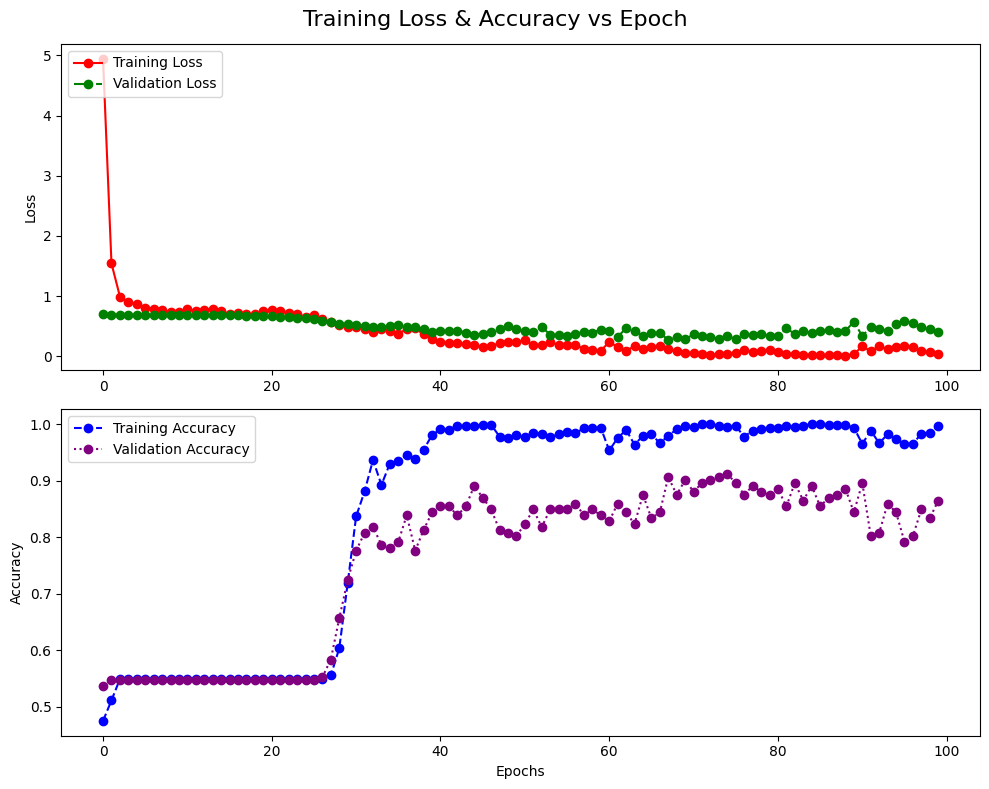

In [ ]:
epoch_log = [*range(epochs)]

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  # 2 filas, 1 columna

# Título y rotación del eje x
fig.suptitle("Training Loss & Accuracy vs Epoch", fontsize=16)
ax2.set_xlabel('Epochs')

# Crear las líneas para los datos de entrenamiento (colores y estilos personalizados)
ax1.plot(epoch_log, train_loss, color='red', linestyle='-', marker='o', label='Training Loss')
ax2.plot(epoch_log, train_accuracy, color='blue', linestyle='--', marker='o', label='Training Accuracy')

# Crear las líneas para los datos de validación (colores y estilos personalizados)
ax1.plot(epoch_log, val_loss, color='green', linestyle='-.', marker='o', label='Validation Loss')
ax2.plot(epoch_log, val_accuracy, color='purple', linestyle=':', marker='o', label='Validation Accuracy')

# Configurar ejes y leyendas para el primer subgráfico (pérdida)
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Configurar ejes y leyendas para el segundo subgráfico (precisión)
ax2.set_ylabel('Accuracy', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper left')

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

    # Nombre del archivo PDF
pdf_filename = "graficaFold2_Loss&AccvsEpoch.pdf"

    # Guardar la gráfica en un archivo PDF
plt.savefig(pdf_filename, format='pdf')

# Mostrar la gráfica
plt.show()

# **Evaluación del Modelo con Conjunto de Prueba**

En este bloque de código, se evalúa el modelo utilizando un conjunto de datos de prueba. Se carga el modelo InceptionV3 preentrenado con capas totalmente conectadas personalizadas y se utilizan los pesos del mejor modelo entrenado previamente. Se realizan predicciones en el conjunto de prueba y se calculan diversas métricas de rendimiento, incluyendo la precisión, la precisión ponderada, la recuperación y la puntuación F1. Además, se almacenan las predicciones y etiquetas reales para análisis posterior.

Este proceso proporciona una evaluación detallada del rendimiento del modelo en datos no vistos, permitiendo una comprensión más completa de su calidad y generalización.

Este bloque de código proporciona una evaluación completa del modelo en un conjunto de datos de prueba, permitiendo una comprensión detallada de su rendimiento en situaciones del mundo real.

In [ ]:
# Inicializa listas para almacenar las predicciones y etiquetas reales
all_predictions = []
all_labels = []

# Cargar el modelo InceptionV3 pre-entrenado
model = models.inception_v3(pretrained=True, aux_logits=True)
num_features = model.fc.in_features  # Obtener el número de características de entrada
# Definir tus propias capas FC
fc0 = nn.Linear(num_features, 1024)
fc1 = nn.Linear(1024, 512)  # Agrega la primera capa FC con 512 neuronas
fc2 = nn.Linear(512, 256)  # Agrega la segunda capa FC con 256 neuronas
fc3 = nn.Linear(256, num_classes)  # Agrega la tercera capa FC con 2 neuronas (suponiendo 2 clases)

# Reemplazar la capa FC existente en InceptionV3 con tus nuevas capas FC
model.fc = nn.Sequential(
    fc0,
    nn.ReLU(),
    fc1,
    nn.ReLU(),  # Agrega una función de activación, por ejemplo, ReLU
    fc2,
    nn.ReLU(),  # Otra función de activación, por ejemplo, ReLU
    fc3
)

model.load_state_dict(torch.load('mejor_modelo.pth'))

model.to(device)

# Cambiar el modelo a modo de evaluación
model.eval()

# Inicializa variables para las métricas
total_correct = 0
total_samples = 0

# Inicializa la matriz de confusión
confusion = torch.zeros(num_classes, num_classes)

# Realiza el bucle de prueba
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Realiza predicciones
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Calcula la matriz de confusión
        for t, p in zip(labels.view(-1), predictions.view(-1)):
            confusion[t.long(), p.long()] += 1

        # Calcula las métricas
        total_samples += labels.size(0)
        total_correct += (predictions == labels).sum().item()

        # Almacena las predicciones y etiquetas reales para cálculos posteriores
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcula métricas finales
print('Resultados con el mejor modelo')
accuracy = total_correct / total_samples
precision = precision_score(all_labels, all_predictions, average='micro')
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (r

Resultados con el mejor modelo


# **Resultados de Evaluación**

En esta sección, se imprimen las métricas de rendimiento calculadas durante la evaluación del modelo en el conjunto de datos de prueba. Estas métricas proporcionan una comprensión cuantitativa del rendimiento del modelo en términos de precisión, recuperación y F1-score.

Estos resultados proporcionan información clave sobre el rendimiento del modelo en diferentes aspectos, ayudando a identificar fortalezas y debilidades específicas en su capacidad predictiva.

In [ ]:
# Imprime las métricas y la matriz de confusión
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.8589211618257261
Precision: 0.8589211618257261
Recall: 0.8333333333333334
F1-Score: 0.8661417322834646


# **Visualización de Métricas de Evaluación**

En este bloque de código, se crea una visualización utilizando la biblioteca Matplotlib para representar gráficamente las métricas de evaluación del modelo. Se utilizan los valores de precisión, recuperación, F1-score y exactitud, calculados previamente, para generar un gráfico de barras que proporciona una representación visual de estas métricas.

La figura se guarda en un archivo PDF con el nombre "graficaFold2_Metrics.pdf". Esta visualización es una herramienta efectiva para comunicar de manera clara y concisa cómo el modelo está realizando en términos de diferentes métricas de evaluación.

Esta visualización proporciona una representación intuitiva y fácil de interpretar del rendimiento del modelo en diferentes métricas clave, lo que facilita la comunicación de los resultados a audiencias no técnicas.

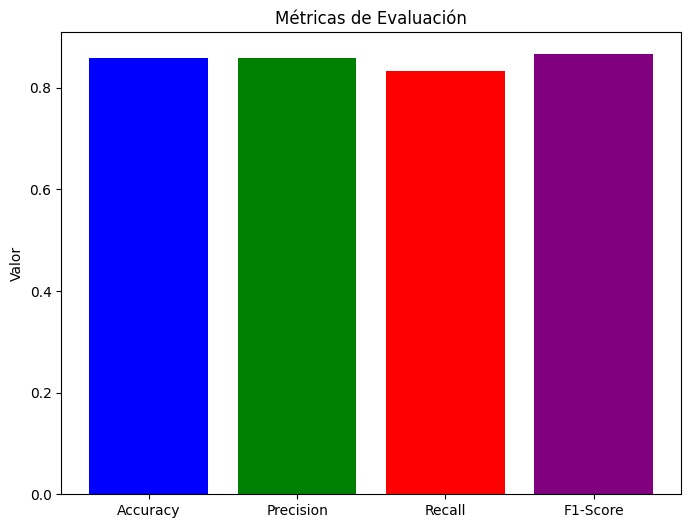

In [ ]:
# Valores de las métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

# Crea una figura de Matplotlib
plt.figure(figsize=(8, 6))

# Crea un gráfico de barras para las métricas
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])

# Etiqueta del eje y
plt.ylabel('Valor')

# Título del gráfico
plt.title('Métricas de Evaluación')

    # Nombre del archivo PDF
pdf_filename2 = "graficaFold2_Metrics.pdf"

plt.savefig(pdf_filename2, format='pdf')

# Muestra el gráfico de barras
plt.show()

# **Visualización de la Matriz de Confusión**

En este bloque de código, se utiliza la biblioteca Matplotlib junto con Seaborn para crear un mapa de calor que representa visualmente la matriz de confusión del modelo. La matriz de confusión es convertida en un DataFrame de pandas para facilitar su visualización, y se utiliza un mapa de calor para resaltar las relaciones entre las clases reales y las predicciones del modelo.

La figura resultante se guarda en un archivo PDF con el nombre "graficaFold2_Matrix.pdf". Esta visualización proporciona una representación clara de cómo el modelo clasifica las muestras en diferentes clases, destacando áreas de aciertos y posibles áreas de confusión.

Esta visualización es esencial para comprender cómo el modelo está realizando las clasificaciones en cada clase, proporcionando información detallada sobre sus aciertos y posibles áreas de mejora.

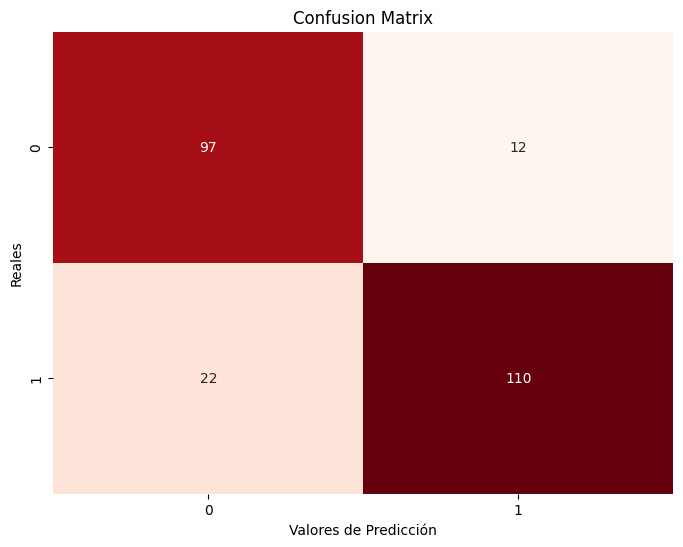

In [ ]:
# Crea una figura de Matplotlib
plt.figure(figsize=(8, 6))

# Convierte la matriz de confusión en un DataFrame de pandas para una mejor visualización
confusion_df = pd.DataFrame(confusion.numpy(), index=range(num_classes), columns=range(num_classes))

# Utiliza Seaborn para crear un mapa de calor
sns.heatmap(confusion_df, annot=True, fmt='g', cmap='Reds', cbar=False)

# Configura etiquetas y títulos
plt.xlabel('Valores de Predicción')
plt.ylabel('Reales')
plt.title('Confusion Matrix')

    # Nombre del archivo PDF
pdf_filename3 = "graficaFold2_Matrix.pdf"

plt.savefig(pdf_filename3, format='pdf')

# Muestra la matriz de confusión
plt.show()